PPG, ECG 신호를 사용해서 특정 환자의 blood pressure estimation
환자번호 p078346

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


총 2000개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 4000

SBP (수축기 혈압):
  - 평균: 133.14 mmHg
  - 최소: 107.62 mmHg
  - 최대: 164.66 mmHg
  - 표준편차: 8.04 mmHg

DBP (이완기 혈압):
  - 평균: 54.52 mmHg
  - 최소: 48.91 mmHg
  - 최대: 73.42 mmHg
  - 표준편차: 1.97 mmHg


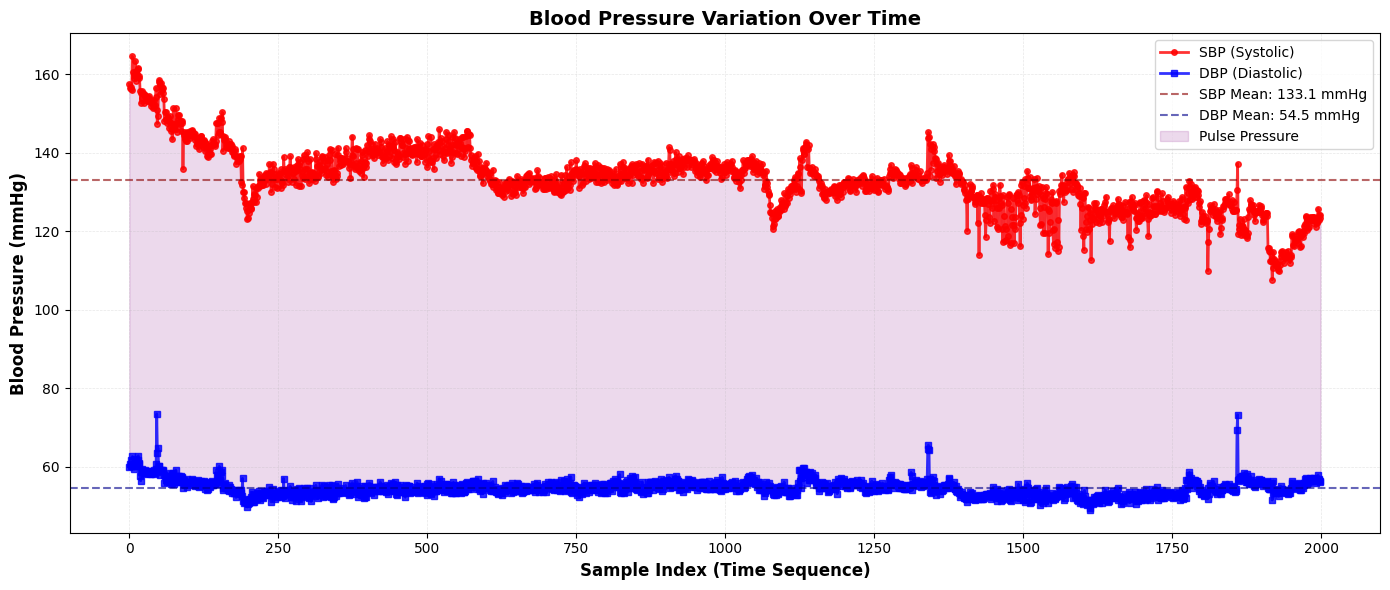


로드 완료: 4000개의 PPG, ECG 세그먼트


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

def load_and_display_bp(mat_path, segment_limit=None):
    """
    MAT 파일에서 PPG 세그먼트와 혈압(SBP, DBP) 데이터를 로드하고 표시

    Args:
        mat_path: .mat 파일 경로
        segment_limit: 로드할 최대 세그먼트 수 (None이면 전체)
    """
    segments, sbp_list, dbp_list = [], [], []

    # MAT 파일 로드
    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']['PPG_F'][0]
        ecg_refs = f['Subj_Wins']['ECG_F'][0]
        sbps = f['Subj_Wins']['SegSBP'][0]
        dbps = f['Subj_Wins']['SegDBP'][0]

        total = min(len(refs), segment_limit) if segment_limit else len(refs)

        print(f"총 {total}개의 세그먼트 로드 중...")

        for i in range(total):
            ppg = f[refs[i]][()].squeeze().astype(np.float32)
            ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments.append(ppg)
            segments.append(ecg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    # 통계 출력
    print(f"\n=== 혈압 데이터 통계 ===")
    print(f"세그먼트 수: {len(segments)}")
    print(f"\nSBP (수축기 혈압):")
    print(f"  - 평균: {np.mean(sbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(sbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(sbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(sbp_list):.2f} mmHg")

    print(f"\nDBP (이완기 혈압):")
    print(f"  - 평균: {np.mean(dbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(dbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(dbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(dbp_list):.2f} mmHg")

    # 시각화
    plot_bp_combined_timeseries(sbp_list, dbp_list)

    return segments, sbp_list, dbp_list


def plot_bp_distribution(sbp_list, dbp_list):
    """혈압 분포 히스토그램"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(sbp_list, bins=30, color='red', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('SBP (mmHg)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('SBP Distribution')
    ax1.axvline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.hist(dbp_list, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('DBP (mmHg)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('DBP Distribution')
    ax2.axvline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_scatter(sbp_list, dbp_list):
    """SBP vs DBP 산점도"""
    plt.figure(figsize=(8, 6))
    plt.scatter(sbp_list, dbp_list, alpha=0.6, s=50, c=range(len(sbp_list)),
                cmap='viridis', edgecolors='black', linewidth=0.5)

    plt.xlabel('SBP (mmHg)', fontsize=12)
    plt.ylabel('DBP (mmHg)', fontsize=12)
    plt.title('SBP vs DBP Relationship', fontsize=14)
    plt.colorbar(label='Sample Index')
    plt.grid(alpha=0.3)

    # 추세선
    z = np.polyfit(sbp_list, dbp_list, 1)
    p = np.poly1d(z)
    plt.plot(sorted(sbp_list), p(sorted(sbp_list)), "r--",
             linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_bp_timeseries(sbp_list, dbp_list):
    """시간 순서에 따른 SBP/DBP 변화 그래프"""
    time_idx = np.arange(len(sbp_list))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # SBP 시계열
    ax1.plot(time_idx, sbp_list, color='red', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='SBP')
    ax1.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.fill_between(time_idx, sbp_list, alpha=0.2, color='red')
    ax1.set_ylabel('SBP (mmHg)', fontsize=12, fontweight='bold')
    ax1.set_title('Systolic Blood Pressure Over Time', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)

    # DBP 시계열
    ax2.plot(time_idx, dbp_list, color='blue', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='DBP')
    ax2.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.fill_between(time_idx, dbp_list, alpha=0.2, color='blue')
    ax2.set_xlabel('Sample Index (Time Sequence)', fontsize=12)
    ax2.set_ylabel('DBP (mmHg)', fontsize=12, fontweight='bold')
    ax2.set_title('Diastolic Blood Pressure Over Time', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_combined_timeseries(sbp_list, dbp_list):
    """SBP와 DBP를 하나의 그래프에 표시 (흰색 배경)"""
    time_idx = np.arange(len(sbp_list))

    fig = plt.figure(figsize=(14, 6), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')

    # SBP와 DBP 라인 플롯
    ax.plot(time_idx, sbp_list, color='red', linewidth=2,
            marker='o', markersize=4, alpha=0.8, label='SBP (Systolic)')
    ax.plot(time_idx, dbp_list, color='blue', linewidth=2,
            marker='s', markersize=4, alpha=0.8, label='DBP (Diastolic)')

    # 평균선
    ax.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'SBP Mean: {np.mean(sbp_list):.1f} mmHg')
    ax.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'DBP Mean: {np.mean(dbp_list):.1f} mmHg')

    # 영역 채우기 (맥압 표시)
    ax.fill_between(time_idx, sbp_list, dbp_list, alpha=0.15, color='purple',
                    label='Pulse Pressure')

    ax.set_xlabel('Sample Index (Time Sequence)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Blood Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Pressure Variation Over Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # 배경색 명시적으로 흰색 설정
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()


def plot_sample_ppg_with_bp(segments, sbp_list, dbp_list, n_samples=5):
    """샘플 PPG 신호와 혈압 값 표시"""
    n = min(n_samples, len(segments))
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))

    if n == 1:
        axes = [axes]

    for i in range(n):
        ppg = segments[i]
        sbp = sbp_list[i]
        dbp = dbp_list[i]

        axes[i].plot(ppg, color='black', linewidth=1.2)
        axes[i].set_title(f'Sample {i+1} | SBP: {sbp:.1f} mmHg | DBP: {dbp:.1f} mmHg',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('PPG Amplitude')
        axes[i].grid(alpha=0.3)

        # 혈압 정보를 텍스트로 추가
        axes[i].text(0.02, 0.95, f'SBP: {sbp:.1f}\nDBP: {dbp:.1f}',
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


# ============ 실행 예제 ============
if __name__ == '__main__':
    # 파일 경로 설정
    MAT_FILE = "/content/drive/MyDrive/Colab Notebooks/p078346.mat"

    # 데이터 로드 및 표시 (2000개 세그먼트만)
    segments, sbp_values, dbp_values = load_and_display_bp(
        mat_path=MAT_FILE,
        segment_limit=2000
    )

    print(f"\n로드 완료: {len(segments)}개의 PPG, ECG 세그먼트")

In [3]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, InputLayer

# ---------------------------------------------------------
# 1. 데이터 준비 (PPG + ECG → 2채널)
# ---------------------------------------------------------
# segments, sbp_values, dbp_values 가 이미 로드되어 있다고 가정
# segments: list of PPG (len=segment_count)
# You also have ECG → 같은 index에서 길이 동일하다고 가정

def build_dataset(ppg_segments, ecg_segments, sbp, dbp):
    X = []
    for ppg, ecg in zip(ppg_segments, ecg_segments):
        sig = np.stack([ppg, ecg], axis=1)  # (timesteps, 2 channels)
        X.append(sig)

    X = np.array(X, dtype=np.float32)
    y = np.column_stack([sbp, dbp])  # (samples, 2)

    return X, y


# ---------------------------------------------------------
# 2. CNN 모델 생성 함수
# ---------------------------------------------------------
def create_cnn_model(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv1D(32, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='linear')  # SBP, DBP 2개 회귀 출력
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    return model


# ---------------------------------------------------------
# 3. 5-Fold (Train 300, Test 100)
# ---------------------------------------------------------
def run_5fold_cv(ppg_segments, ecg_segments, sbp_values, dbp_values):
    X, y = build_dataset(ppg_segments, ecg_segments, sbp_values, dbp_values)

    # 입력 정규화
    samples, timesteps, channels = X.shape
    X_reshaped = X.reshape(samples, -1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped).reshape(samples, timesteps, channels)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae_list = []
    rmse_list = []

    fold = 1

    for train_idx, test_idx in kf.split(X_scaled):
        # fold 크기 재조정 (Train 300, Test 100로 강제 통일)
        train_idx = train_idx[:300]
        test_idx = test_idx[:100]

        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        print(f"\n===== Fold {fold} =====")
        print(f"Train: {len(X_train)}, Test: {len(X_test)}")

        model = create_cnn_model((timesteps, channels))

        model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            verbose=0,

        )

        pred = model.predict(X_test, verbose=0)

        mae = mean_absolute_error(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))

        mae_list.append(mae)
        rmse_list.append(rmse)

        print(f"Fold {fold} | MAE: {mae:.4f}, RMSE: {rmse:.4f}")

        fold += 1

    # 전체 통계
    print("\n============================")
    print("5-Fold Cross Validation 결과")
    print("============================")
    print(f"MAE 평균: {np.mean(mae_list):.4f},  표준편차: {np.std(mae_list):.4f}")
    print(f"RMSE 평균: {np.mean(rmse_list):.4f}, 표준편차: {np.std(rmse_list):.4f}")

    return mae_list, rmse_list


# ---------------------------------------------------------
# 실행 예제 (segments, sbp_values, dbp_values는 이미 로드됨)
# ---------------------------------------------------------
# segments -> PPG 리스트
# ecg_segments -> ECG 리스트

# segments 리스트에서 1~2000번째 항목이 PPG, 2001~4000번째 항목이 ECG
run_5fold_cv(segments[:2000], segments[2000:], sbp_values, dbp_values)



===== Fold 1 =====
Train: 300, Test: 100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Fold 1 | MAE: 5.0043, RMSE: 6.6831

===== Fold 2 =====
Train: 300, Test: 100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Fold 2 | MAE: 5.3492, RMSE: 7.7383

===== Fold 3 =====
Train: 300, Test: 100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Fold 3 | MAE: 6.2166, RMSE: 8.4090

===== Fold 4 =====
Train: 300, Test: 100
Fold 4 | MAE: 4.5575, RMSE: 7.2831

===== Fold 5 =====
Train: 300, Test: 100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Fold 5 | MAE: 4.3946, RMSE: 6.4151

5-Fold Cross Validation 결과
MAE 평균: 5.1044,  표준편차: 0.6496
RMSE 평균: 7.3057, 표준편차: 0.7191


([5.004255499765042,
  5.3491801025364225,
  6.21664067156742,
  4.557456620526311,
  4.394587424979017],
 [np.float64(6.68313792629344),
  np.float64(7.738270535533367),
  np.float64(8.408956528731766),
  np.float64(7.283121389406172),
  np.float64(6.415109955109922)])

In [13]:
# 새로운 환자 예측에 사용하기 위해 모델 저장 및 불러오기 기능

# ---------------------------------------------------------
# 4. 모델 저장 기능 추가
# ---------------------------------------------------------
def train_and_save_model(ppg_segments, ecg_segments, sbp_values, dbp_values, save_path="bp_cnn.h5", scaler_path="scaler.pkl"):
    from joblib import dump

    X, y = build_dataset(ppg_segments, ecg_segments, sbp_values, dbp_values)

    # ----- 스케일링 -----
    samples, timesteps, channels = X.shape
    X_flat = X.reshape(samples, -1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat).reshape(samples, timesteps, channels)

    # ----- 전체 데이터로 최종 모델 학습 -----
    model = create_cnn_model((timesteps, channels))

    model.fit(
        X_scaled, y,
        epochs=20,
        batch_size=32,
        verbose=1
    )

    # ----- 모델 & 스케일러 저장 -----
    model.save(save_path)
    dump(scaler, scaler_path)

    print(f"\n모델 저장 완료: {save_path}")
    print(f"스케일러 저장 완료: {scaler_path}")


# ---------------------------------------------------------
# 5. 저장된 모델을 불러와 새로운 환자 데이터 예측
# ---------------------------------------------------------
def load_model_and_predict(ppg_segments_new, ecg_segments_new, model_path="bp_cnn.h5", scaler_path="scaler.pkl"):
    from tensorflow.keras.models import load_model
    from joblib import load

    # ----- 1) 모델 & 스케일러 로드 -----
    model = load_model(model_path)
    scaler = load(scaler_path)

    # ----- 2) 새로운 환자 데이터 → (samples, timesteps, 2 channels) -----
    # ppg_segments_new, ecg_segments_new는 학습 때와 동일한 방식으로 segment된 리스트여야 함.
    y_dummy = np.zeros(len(ppg_segments_new))  # label 없음 → placeholder
    X_new, _ = build_dataset(ppg_segments_new, ecg_segments_new, y_dummy, y_dummy)

    samples, timesteps, channels = X_new.shape

    # ----- 3) 스케일링 → 학습 때의 scaler 그대로 적용 -----
    X_flat_new = X_new.reshape(samples, -1)
    X_scaled_new = scaler.transform(X_flat_new).reshape(samples, timesteps, channels)

    # ----- 4) 예측 -----
    pred = model.predict(X_scaled_new)

    # pred[:, 0] = SBP, pred[:, 1] = DBP
    return pred


# ---------------------------------------------------------
# 6. 새로운 환자 예측 예제
# ---------------------------------------------------------
def example_predict_new_patient(new_ppg_segments, new_ecg_segments, sbp_values, dbp_values):
    preds = load_model_and_predict(new_ppg_segments, new_ecg_segments)

    print("=== 새로운 환자 예측 결과 (앞 20개) ===")
    for i in range(min(20, len(preds))):
        sbp, dbp = preds[i]
        sbp_value, dbp_value = sbp_values[i], dbp_values[i]
        print(f"Segment {i} loss: SBP={abs(sbp-sbp_value):.2f}, DBP={abs(dbp-dbp_value):.2f}")


In [9]:
train_and_save_model(
    segments[:2000], segments[2000:], sbp_values, dbp_values,
    save_path="bp_cnn.h5",
    scaler_path="scaler.pkl"
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 3053.7769
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 292.2820
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 260.8788
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 245.7552
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 212.6023
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 209.3746
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 197.3769
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 175.9115
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 181.7622
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 201.4099
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 178.5640
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 184.1220
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 161.8041
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 166.5205
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms


모델 저장 완료: bp_cnn.h5
스케일러 저장 완료: scaler.pkl


총 2000개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 4000

SBP (수축기 혈압):
  - 평균: 131.73 mmHg
  - 최소: 94.86 mmHg
  - 최대: 176.10 mmHg
  - 표준편차: 11.22 mmHg

DBP (이완기 혈압):
  - 평균: 63.62 mmHg
  - 최소: 54.37 mmHg
  - 최대: 125.27 mmHg
  - 표준편차: 5.80 mmHg


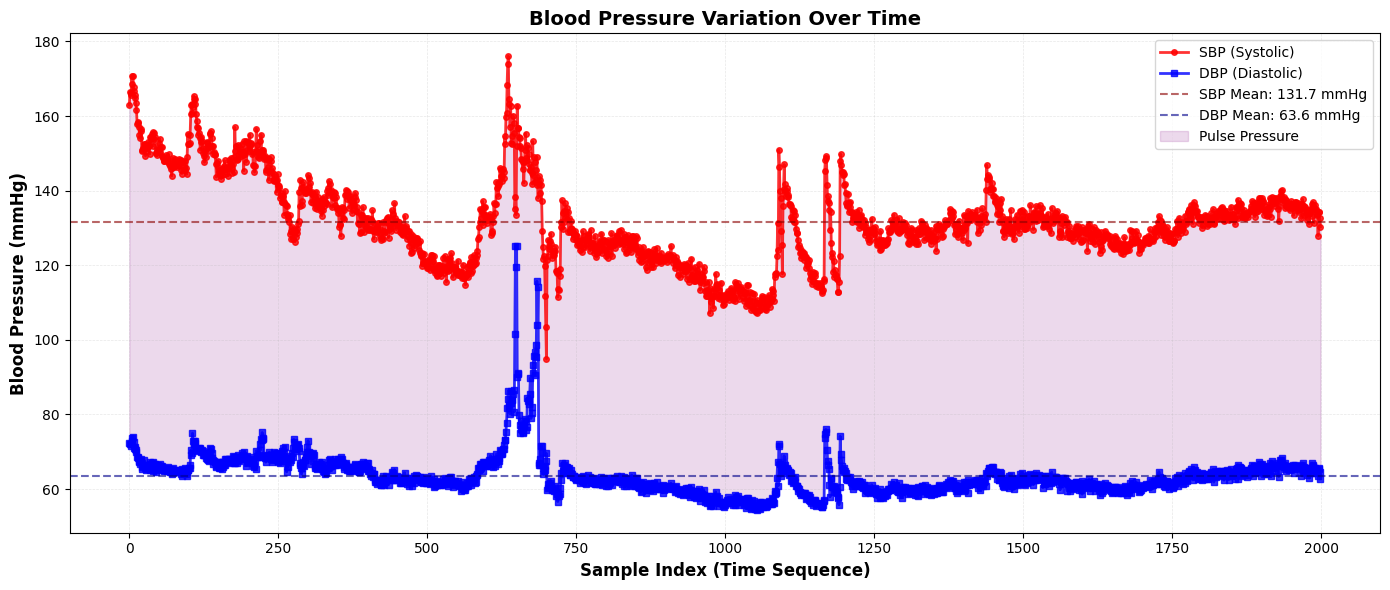


로드 완료: 4000개의 PPG, ECG 세그먼트


In [10]:
MAT_FILE = "/content/drive/MyDrive/Colab Notebooks/p093640.mat"

# 데이터 로드 및 표시 (2000개 세그먼트만)
segments, sbp_values, dbp_values = load_and_display_bp(
    mat_path=MAT_FILE,
    segment_limit=2000
)

print(f"\n로드 완료: {len(segments)}개의 PPG, ECG 세그먼트")

In [14]:
example_predict_new_patient(segments[:2000], segments[2000:], sbp_values, dbp_values)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
=== 새로운 환자 예측 결과 (앞 20개) ===
Segment 0 loss: SBP=39.34, DBP=11.65
Segment 1 loss: SBP=31.65, DBP=8.44
Segment 2 loss: SBP=34.27, DBP=9.45
Segment 3 loss: SBP=24.25, DBP=6.16
Segment 4 loss: SBP=45.70, DBP=12.88
Segment 5 loss: SBP=31.02, DBP=8.11
Segment 6 loss: SBP=45.18, DBP=14.18
Segment 7 loss: SBP=32.94, DBP=7.48
Segment 8 loss: SBP=42.27, DBP=12.48
Segment 9 loss: SBP=31.51, DBP=6.74
Segment 10 loss: SBP=35.59, DBP=10.18
Segment 11 loss: SBP=26.68, DBP=7.64
Segment 12 loss: SBP=37.73, DBP=10.13
Segment 13 loss: SBP=18.42, DBP=3.03
Segment 14 loss: SBP=34.87, DBP=8.64
Segment 15 loss: SBP=28.72, DBP=7.29
Segment 16 loss: SBP=39.08, DBP=9.26
Segment 17 loss: SBP=22.60, DBP=3.09
Segment 18 loss: SBP=26.56, DBP=4.36
Segment 19 loss: SBP=24.25, DBP=4.42
